# Process HLA Imputation
Process output of SNP2HLA.py imputation and call alleles for each sample, for use in personalized HLA quantification pipeline.

Joyce Kang & Sid Gurajala

Last updated June 2023

In [1]:
#install.packages('vcfR')
suppressPackageStartupMessages({
    library(vcfR)
    library(tidyr)
    library(ggplot2)
    library(dplyr)
    library(stringr)
    library(tidyverse)
    library(RColorBrewer)
})

source('../utils.R')

# New Panel | SNP2HLA | AMP2RA

## Read in imputation file

In [2]:
# HLA imputation performed by Saori Sakaue
vcf_filepath = paste0('/data/srlab/ssakaue/share/forJoyce/post_merged_auto.final.MHC.SNP2HLA.bgl.phased.vcf.gz')
vcf = read.vcfR(vcf_filepath, verbose = FALSE)
vcf@fix %>% head(4)
vcf@gt %>% head(4)

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,27970031,rs149946,G,T,NA,PASS,AR2=0.98;DR2=0.98;AF=0.27;IMP
6,27976200,rs9380032,G,T,NA,PASS,AR2=0.95;DR2=0.95;AF=0.051;IMP
6,27979188,rs4141691,A,G,NA,PASS,AR2=0.90;DR2=0.92;AF=0.12;IMP
6,27979625,rs10484402,A,G,NA,PASS,AR2=0.89;DR2=0.91;AF=0.060;IMP


FORMAT,200-0034-W24-02-C1,200-0056,200-0351,200-0037-W24-02-C1,200-0394,200-0883,200-0038-W24-02-C2,200-1218,300-0472,⋯,200-1252,200-0136,200-2120,200-0891,300-0418,200-1025,200-2120a,200-0891a,300-0418a,200-1025a
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:1:0,1,0","1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0",⋯,"0|1:1:0,1,0","1|0:1:0,1,0","0|0:0:1,0,0","1|1:2:0,0,1","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","1|1:2:0,0,1","0|1:1:0,1,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","1|0:0.96:0.04,0.96,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0.46:0.54,0.46,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|1:0.96:0.04,0.96,0","1|1:1.76:0.01,0.22,0.77","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"


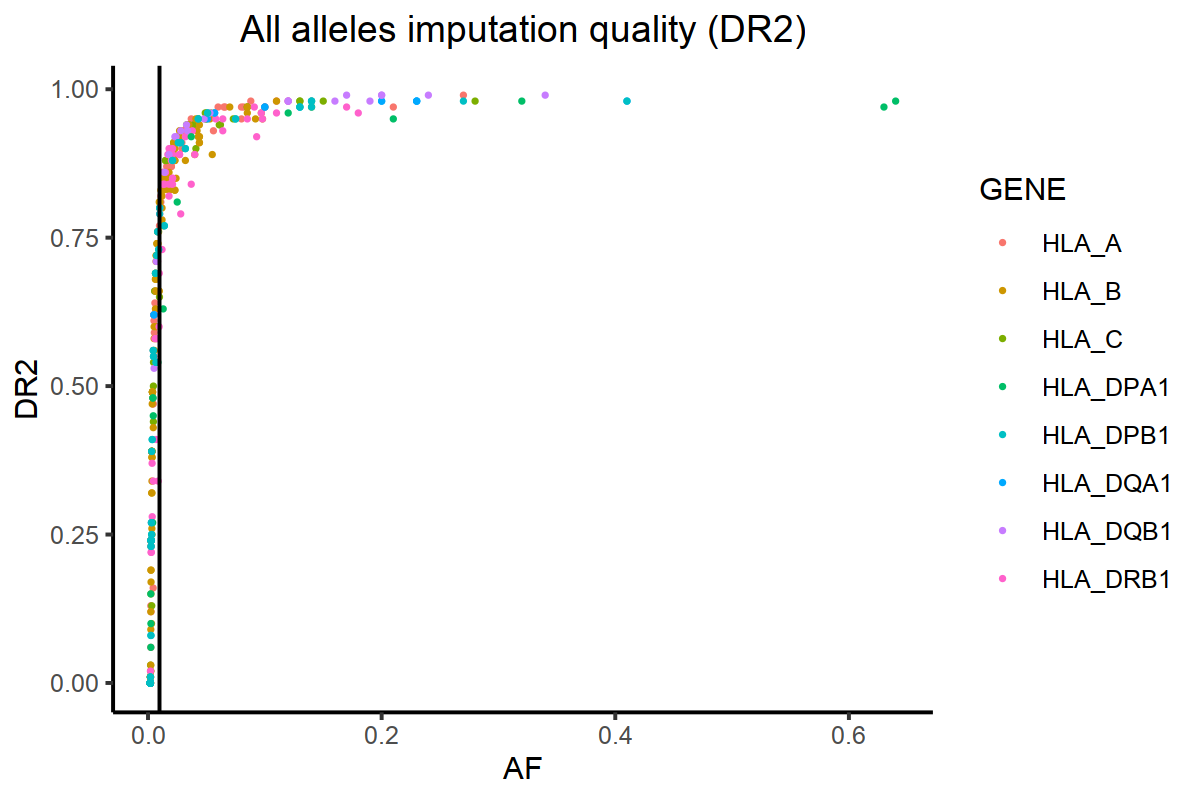

In [3]:
fig.size(4, 6)
res = make_imputation_results(vcf_filepath)
res$p2

## Imputation quality for 4-digit alleles

In [4]:
vcf_4digit = res$vcf_fix_df[which(res$vcf_fix_df$ndigit == 4), ]
length(unique(vcf_4digit$ID))
vcf_4digit_AMP = vcf_4digit %>% mutate(dataset = 'AMP')

## Subset to only include MAF>1%
AMP_maf1 = vcf_4digit[which(vcf_4digit$AF > 0.01), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

## Subset to only include MAF>1%
AMP_maf5 = vcf_4digit[which(vcf_4digit$AF > 0.05), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

[1] 423

## Get inferred HLA alleles for each individual

In [5]:
d = cbind(res$vcf_fix_df, res$vcf_hla@gt) %>% as.data.frame()

samples = colnames(res$vcf_hla@gt)
samples = samples[-1] # remove FORMAT column
length(samples)

[1] 788

## Subset to AMP2RA samples

In [6]:
sample_meta <- read.csv("../../data/meta/sample_meta_AMP2RA.csv")

In [7]:
results = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] %>% filter(ndigit > 2)
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    # Add check for when alleles are flipped (ref/alt): 0|0 means homozygous for HLA allele.
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results[[samp]] = d_samp_haszero %>% filter(count == 1 | count == 2)
}
saveRDS(results, '../../data/hla_alleles/AMPRA_updated.new.ref_results.rds')

In [8]:
## Save full result
results_allAlleles = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] 
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results_allAlleles[[samp]] = d_samp_haszero
}

saveRDS(results_allAlleles, '../../data/hla_alleles/AMPRA_updated.new.ref_all.results.rds')

## Manual inspection

In [9]:
nrow(sample_meta)

[1] 78

In [10]:
df_missing <- data.frame(0,0,0)
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    res = results[[samp]]
    
    gene_sums = tapply(res$count, res$GENE, sum)
    count_sum = sum(res$count)
    
    for (gene in c("HLA_A", "HLA_B", "HLA_C", "HLA_DRB1", "HLA_DQA1", "HLA_DQB1", "HLA_DPB1", "HLA_DPA1")) {
    if (gene_sums[gene] != 2 | is.na(gene_sums[gene])) {
        df_missing <- rbind(df_missing, c(samp, gene, gene_sums[gene]))
        #print(res)
    }
 }
}
df_missing <- df_missing[-1, ]

In [11]:
df_missing

,X0,X0.1,X0.2
,<chr>,<chr>,<chr>
2,300-0143,HLA_B,1
3,300-0143,HLA_DPA1,1
4,300-1934,HLA_A,1
5,300-2666,HLA_DRB1,1
6,300-0531,HLA_A,1
7,300-0413,HLA_DRB1,1
8,300-2658,HLA_DRB1,1
9,300-0411-V0-14-C1,HLA_DRB1,1
10,300-0469-F2-16-PXD1,HLA_C,1


Individuals without two phased alleles for every HLA gene: 9

In [12]:
results_allAlleles[['300-0143']] %>% filter(GENE =='HLA_DPA1', dosage != 0)

REF,ID,GENE,geno01,col1,col2,ndigit,count,dosage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
A,HLA_DPA1*02,HLA_DPA1,0|1,1.24,"0,0.75,0.24",2,1,1.24
A,HLA_DPA1*02:01,HLA_DPA1,0|1,1.24,"0,0.75,0.24",4,1,1.24
A,HLA_DPA1*03,HLA_DPA1,1|0,0.76,"0.24,0.75,0",2,1,0.76


In [13]:
results <- results[- which(names(results) %in% df_missing$X0)] # remove missing individuals
sample_names <- vector()
i = 0
for (name in names(results)) {
    res = results[[name]][,c('ID', 'GENE', 'count')]
    # List of alleles (save as XXX-XXX_alleles.txt)
    sample_name <- sample_meta[sample_meta$Geno_ID == name, 'Sample']
    sample_names <- c(sample_names, sample_name)
    write.csv(res, paste0('../../data/hla_alleles/RA_updated_alleles/', 
                          sample_name, '_alleles.csv'), row.names = FALSE, quote = FALSE)
    i = i + 1
}
print(i)
write.table(data.frame(names(results), sample_names), 
            "../../data/hla_alleles/RA_updated_alleles/AMP2RA_final_samples.txt", 
            col.names = FALSE, row.names = FALSE, quote = FALSE)

[1] 69


In [14]:
## Make Supplementary Table
results_table = bind_rows(results, .id = 'Geno_ID') %>% select(Geno_ID, ID, GENE, geno01, dosage)
rownames(results_table) = c(1:nrow(results_table))
results_table = left_join(results_table, sample_meta[, c('Geno_ID', 'Sample')], by = 'Geno_ID')[, c(1, 6, 2, 3, 4, 5)]
colnames(results_table) = c('Geno_ID', 'Sample', 'Allele', 'Gene', 'GT', 'dosage')
write.csv(results_table, '../../data/hla_alleles/HLA_alleles_table_AMP2RA.csv')
results_table %>% head(4)
results_table$Sample %>% unique() %>% length()

,Geno_ID,Sample,Allele,Gene,GT,dosage
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,301-0267,BRI-399,HLA_A*01:01,HLA_A,0|1,1.00
2,301-0267,BRI-399,HLA_A*02:01,HLA_A,1|0,0.97
3,301-0267,BRI-399,HLA_C*05:01,HLA_C,1|0,1.00
4,301-0267,BRI-399,HLA_C*07:01,HLA_C,0|1,1.00


[1] 69

# New Panel | SNP2HLA | Smillie CCDG Broad

## Read in imputation file

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,27970031,rs149946,G,T,NA,PASS,AR2=0.96;DR2=0.96;AF=0.22;IMP
6,27976200,rs9380032,G,T,NA,PASS,AR2=0.93;DR2=0.93;AF=0.039;IMP
6,27979188,rs4141691,A,G,NA,PASS,AR2=0.89;DR2=0.90;AF=0.11;IMP
6,27979625,rs10484402,A,G,NA,PASS,AR2=0.93;DR2=0.93;AF=0.043;IMP


FORMAT,202279080003_R03C01,202279080003_R03C02,202279080003_R04C01,202279080003_R04C02,202279080003_R05C01,202279080003_R05C02,202279080003_R06C01,202279080003_R06C02,202279080003_R07C01,⋯,203672280147_R08C01,203672280147_R08C02,203672280147_R09C01,203672280147_R09C02,203672280147_R10C01,203672280147_R10C02,203672280147_R11C01,203672280147_R11C02,203672280147_R12C01,203672280147_R12C02
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.96:0.04,0.96,0","0|1:1:0,1,0","0|0:0:1,0,0","0|1:0.96:0.04,0.96,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:0.96:0.04,0.96,0","1|1:1.82:0,0.17,0.82","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"1|0:0.95:0.06,0.94,0","1|0:0.96:0.04,0.96,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:0.98:0.03,0.97,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0"


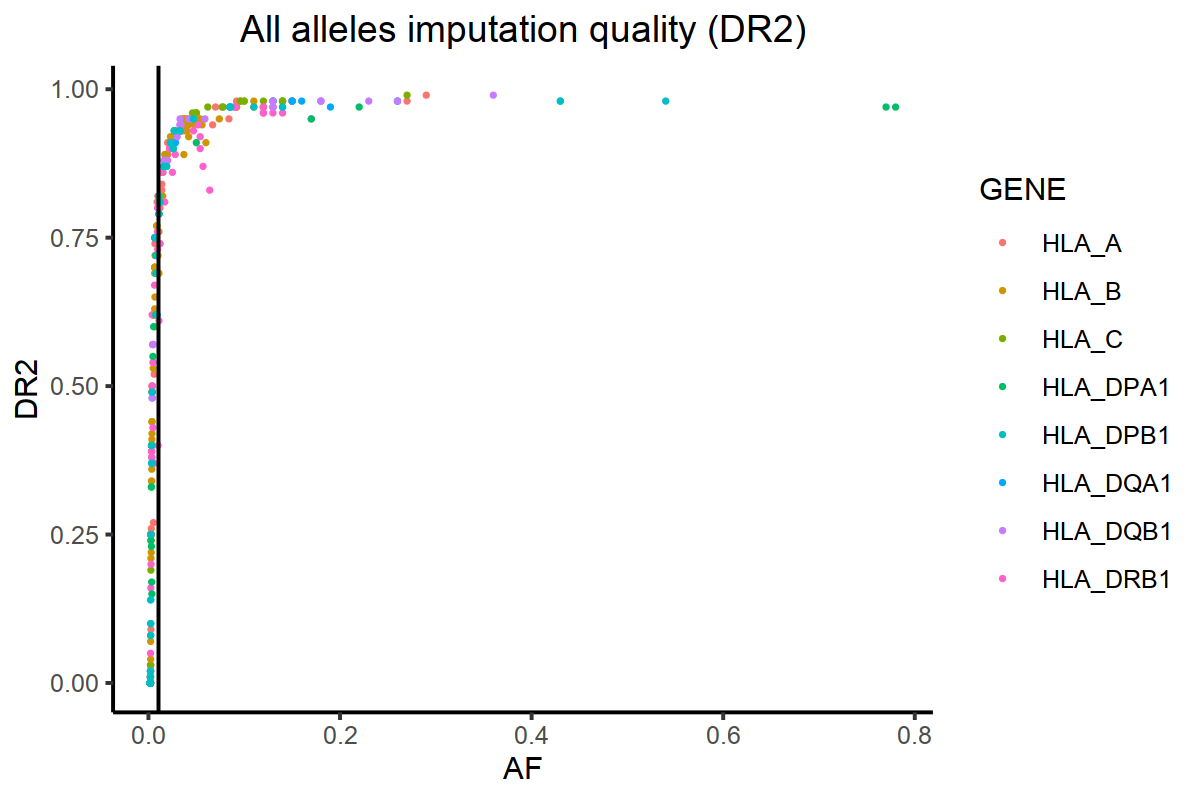

In [15]:
# HLA imputation performed by Saori Sakaue
vcf_filepath = paste0('/data/srlab/ssakaue/share/forJoyce/ccdg_broad.final.maf0.01.MHC.SNP2HLA.bgl.phased.vcf.gz')
vcf = read.vcfR(vcf_filepath, verbose = FALSE)
vcf@fix %>% head(4)
vcf@gt %>% head(4)

res = make_imputation_results(vcf_filepath)
res$p2

## Imputation quality for 4-digit alleles

In [16]:
vcf_4digit = res$vcf_fix_df[which(res$vcf_fix_df$ndigit == 4), ]
length(unique(vcf_4digit$ID))
vcf_4digit_Smillie1 = vcf_4digit %>% mutate(dataset = 'Smillie (GSA)')

## Subset to only include MAF>1%
Smillie1_maf1 = vcf_4digit[which(vcf_4digit$AF > 0.01), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

## Subset to only include MAF>1%
Smillie1_maf5 = vcf_4digit[which(vcf_4digit$AF > 0.05), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

[1] 423

## Get Inferred HLA alleles for each individual

In [17]:
d = cbind(res$vcf_fix_df, res$vcf_hla@gt) %>% as.data.frame()

samples = colnames(res$vcf_hla@gt)
samples = samples[-1] # remove FORMAT column
length(samples)

[1] 765

## Subset to IBD samples

In [18]:
sample_meta <- read.csv("../../data/meta/sample_meta_Smillie.csv")

In [19]:
# Get list of confidently called alleles
results = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] %>% filter(ndigit > 2)
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results[[samp]] = d_samp_haszero %>% filter(count == 1 | count == 2)
}
saveRDS(results, '../../data/hla_alleles/ccdg_updated.new.ref_results.rds')

In [20]:
## NEW: save full result.
results_allAlleles = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] 
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results_allAlleles[[samp]] = d_samp_haszero
}
saveRDS(results_allAlleles, '../../data/hla_alleles/ccdg_updated.new.ref_all.results.rds')

## Manual inspection

In [21]:
df_missing <- data.frame(0,0,0)
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    res = results[[samp]]
    
    gene_sums = tapply(res$count, res$GENE, sum)
    count_sum = sum(res$count)
    
    for (gene in c("HLA_A", "HLA_B", "HLA_C", "HLA_DRB1", "HLA_DQA1", "HLA_DQB1", "HLA_DPB1", "HLA_DPA1")) {
    if (gene_sums[gene] != 2) {
        df_missing <- rbind(df_missing, c(samp, gene, gene_sums[gene]))
        #print(res)
    }
 }
}
df_missing <- df_missing[-1, ]

In [22]:
df_missing

,X0,X0.1,X0.2
,<chr>,<chr>,<chr>
2,203259090242_R02C01,HLA_B,1


In [23]:
results <- results[- which(names(results) %in% df_missing$X0)]
sample_names <- vector()
i = 0
for (name in names(results)) {
    res = results[[name]][,c('ID', 'GENE', 'count')]
    # List of alleles (save as XXX-XXX_alleles.txt)
    sample_name <- sample_meta[sample_meta$Geno_ID == name, 'Sample']
    write.csv(res, paste0('../../data/hla_alleles/ccdg_broad/', 
                          sample_name, '_alleles.csv'), row.names = FALSE, quote = FALSE)
    i = i + 1
    sample_names <- c(sample_names, sample_name)
}
print(i)
write.table(data.frame(names(results), sample_names), 
            "../../data/hla_alleles/ccdg_broad/ccdg_final_samples.txt", 
            col.names = FALSE, row.names = FALSE, quote = FALSE)

[1] 14


In [24]:
## Make Supplementary Table
results_table = bind_rows(results, .id = 'Geno_ID') %>% select(Geno_ID, ID, GENE, geno01, dosage)
rownames(results_table) = c(1:nrow(results_table))
results_table = left_join(results_table, sample_meta[, c('Geno_ID', 'Sample')], by = 'Geno_ID')[, c(1, 6, 2, 3, 4, 5)]
colnames(results_table) = c('Geno_ID', 'Sample', 'Allele', 'Gene', 'GT', 'dosage')
write.csv(results_table, '../../data/hla_alleles/HLA_alleles_table_Smillie_ccdg.csv')
results_table %>% head(4)
results_table$Sample %>% unique() %>% length()

,Geno_ID,Sample,Allele,Gene,GT,dosage
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,202279080102_R08C01,N24,HLA_A*03:01,HLA_A,1|0,1.00
2,202279080102_R08C01,N24,HLA_A*11:01,HLA_A,0|1,0.95
3,202279080102_R08C01,N24,HLA_C*04:01,HLA_C,1|1,2.00
4,202279080102_R08C01,N24,HLA_B*35:01,HLA_B,0|1,0.88


[1] 14

# New Panel | SNP2HLA | Smillie Helmsley 
(PRISM and Xavier merged)

## Read in imputation file


CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,27970031,rs149946,G,T,NA,PASS,AR2=0.96;DR2=0.97;AF=0.22;IMP
6,27976200,rs9380032,G,T,NA,PASS,AR2=0.83;DR2=0.85;AF=0.035;IMP
6,27979188,rs4141691,A,G,NA,PASS,AR2=0.85;DR2=0.86;AF=0.11;IMP
6,27979625,rs10484402,A,G,NA,PASS,AR2=0.83;DR2=0.85;AF=0.037;IMP


FORMAT,200554340003_R01C01,200554340003_R01C02,200554340003_R02C01,200554340003_R02C02,200554340003_R03C01,200554340003_R03C02,200554340003_R04C01,200554340003_R04C02,200554340003_R05C01,⋯,200557070155_R07C02,200557070155_R08C01,200557070155_R08C02,200557070155_R09C01,200557070155_R09C02,200557070155_R10C01,200557070155_R10C02,200557070155_R11C01,200557070155_R11C02,200557070155_R12C02
GT:DS:GP,"0|0:0:1,0,0","1|0:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0",⋯,"1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","1|1:2:0,0,1","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.03,0.97,0","0|0:0:1,0,0",⋯,"0|0:0.02:0.98,0.02,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.97:0.03,0.97,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:0.94:0.06,0.94,0",⋯,"0|1:0.52:0.49,0.51,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0.46:0.54,0.46,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"


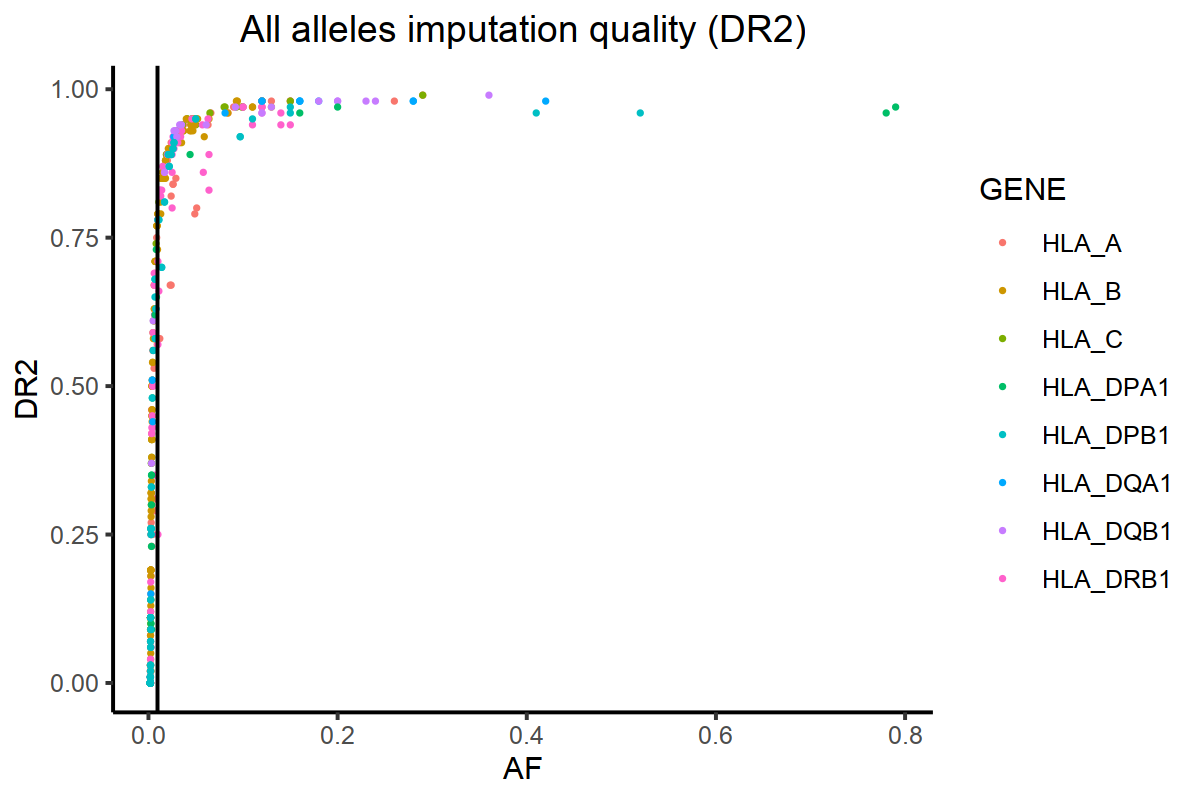

In [25]:
vcf_filepath = paste0('/data/srlab/ssakaue/share/forJoyce/Helmsley_merged_final.maf0.01.MHC.SNP2HLA.bgl.phased.vcf.gz')
vcf = read.vcfR(vcf_filepath, verbose = FALSE)
vcf@fix %>% head(4)
vcf@gt %>% head(4)

res = make_imputation_results(vcf_filepath)
res$p2

## Imputation quality for 4-digit alleles

In [26]:
vcf_4digit = res$vcf_fix_df[which(res$vcf_fix_df$ndigit == 4), ]
length(unique(vcf_4digit$ID))
vcf_4digit_Smillie2 = vcf_4digit %>% mutate(dataset = 'Smillie_custom')

## Subset to only include MAF>1%
Smillie2_maf1 = vcf_4digit[which(vcf_4digit$AF > 0.01), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

## Subset to only include MAF>5%
Smillie2_maf5 = vcf_4digit[which(vcf_4digit$AF > 0.05), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

[1] 423

## Get Inferred HLA alleles for each individual

In [27]:
d = cbind(res$vcf_fix_df, res$vcf_hla@gt) %>% as.data.frame()

samples = colnames(res$vcf_hla@gt)
samples = samples[-1] # remove FORMAT column
length(samples)

[1] 2121

## Subset to IBD Samples

In [28]:
sample_meta <- read.csv("../../data/meta/sample_meta_Smillie.csv")

In [29]:
# Get list of confidently called alleles
results = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] %>% filter(ndigit > 2)
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results[[samp]] = d_samp_haszero %>% filter(count == 1 | count == 2)
}
saveRDS(results, '../../data/hla_alleles/Helmsley_updated.new.ref_results.rds')

In [30]:
results_allAlleles = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] %>% filter(ndigit > 2)
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results_allAlleles[[samp]] = d_samp_haszero
}
saveRDS(results_allAlleles, '../../data/hla_alleles/Helmsley_updated.new.ref_all.results.rds')

## Manual inspection

In [31]:
df_missing <- data.frame(0,0,0)
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    res = results[[samp]]
    
    gene_sums = tapply(res$count, res$GENE, sum)
    count_sum = sum(res$count)
    
    for (gene in c("HLA_A", "HLA_B", "HLA_C", "HLA_DRB1", "HLA_DQA1", "HLA_DQB1", "HLA_DPB1", "HLA_DPA1")) {
    if (gene_sums[gene] != 2) {
        df_missing <- rbind(df_missing, c(samp, gene, gene_sums[gene]))
        #print(res)
    }
 }
}
df_missing <- df_missing[-1, ]

In [32]:
df_missing

,X0,X0.1,X0.2
,<chr>,<chr>,<chr>
2,200556980121_R09C01,HLA_A,1
3,200556970035_R10C02,HLA_DRB1,1


In [33]:
results_allAlleles[['200556980121_R09C01']] %>% filter(GENE == 'HLA_A', dosage != 0)

REF,ID,GENE,geno01,col1,col2,ndigit,count,dosage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
A,HLA_A*02:01,HLA_A,0|1,1,"0,0.99,0.01",4,1,1.00
A,HLA_A*25:01,HLA_A,0|0,0.15,"0.85,0.15,0",4,0,0.15
A,HLA_A*26:01,HLA_A,0|0,0.27,"0.73,0.27,0",4,0,0.27
A,HLA_A*26:08,HLA_A,0|0,0.01,"0.99,0.01,0",4,0,0.01
A,HLA_A*29:02,HLA_A,0|0,0.32,"0.68,0.32,0",4,0,0.32
A,HLA_A*34:02,HLA_A,0|0,0.12,"0.88,0.12,0",4,0,0.12
A,HLA_A*66:01,HLA_A,0|0,0.09,"0.91,0.09,0",4,0,0.09
A,HLA_A*66:02,HLA_A,0|0,0.02,"0.98,0.02,0",4,0,0.02
A,HLA_A*66:03,HLA_A,0|0,0.01,"0.99,0.01,0",4,0,0.01


In [34]:
results <- results[- which(names(results) %in% df_missing$X0)]
sample_names <- vector()
i = 0
for (name in names(results)) {
    res = results[[name]][,c('ID', 'GENE', 'count')]
    # List of alleles (save as XXX-XXX_alleles.txt)
    sample_name <- sample_meta[sample_meta$Geno_ID == name, 'Sample']
    write.csv(res, paste0('../../data/hla_alleles/Helmsley_merged/', 
                          sample_name, '_alleles.csv'), row.names = FALSE, quote = FALSE)
    i = i + 1
    sample_names <- c(sample_names, sample_name)
}
print(i)
write.table(data.frame(names(results), sample_names), 
            "../../data/hla_alleles/Helmsley_merged/Helmsley_final_samples.txt", 
            col.names = FALSE, row.names = FALSE, quote = FALSE)

[1] 8


In [35]:
## Make Supplementary Table
results_table = bind_rows(results, .id = 'Geno_ID') %>% select(Geno_ID, ID, GENE, geno01, dosage)
rownames(results_table) = c(1:nrow(results_table))
results_table = left_join(results_table, sample_meta[, c('Geno_ID', 'Sample')], by = 'Geno_ID')[, c(1, 6, 2, 3, 4, 5)]
colnames(results_table) = c('Geno_ID', 'Sample', 'Allele', 'Gene', 'GT', 'dosage')
write.csv(results_table, '../../data/hla_alleles/HLA_alleles_table_Smillie_Helmsley.csv')
results_table %>% head(4)
results_table$Sample %>% unique() %>% length()

,Geno_ID,Sample,Allele,Gene,GT,dosage
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,200557070016_R12C02,N14,HLA_A*11:01,HLA_A,1|0,1
2,200557070016_R12C02,N14,HLA_A*24:02,HLA_A,0|1,1
3,200557070016_R12C02,N14,HLA_C*04:01,HLA_C,0|1,1
4,200557070016_R12C02,N14,HLA_C*07:02,HLA_C,1|0,1


[1] 8

# New Panel | SNP2HLA | Randolph

## Read in imputation file

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,27970031,rs149946,G,T,NA,PASS,AR2=0.99;DR2=0.99;AF=0.32;IMP
6,27976200,rs9380032,G,T,NA,PASS,AR2=0.83;DR2=0.85;AF=0.020;IMP
6,27979188,rs4141691,A,G,NA,PASS,AR2=0.90;DR2=0.91;AF=0.16;IMP
6,27979625,rs10484402,A,G,NA,PASS,AR2=0.88;DR2=0.88;AF=0.054;IMP


FORMAT,EU02,EU03,HMN171215,HMN171216,HMN171217,HMN171218,HMN171219,HMN171220,HMN171221,⋯,HMN83571,HMN83572,HMN83573,HMN83574,HMN83575,HMN83576,HMN83577,HMN83578,HMN83579,HMN83580
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","1|0:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0",⋯,"1|1:2:0,0,1","1|0:1:0,1,0","1|0:1:0,1,0","1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"1|0:0.96:0.04,0.95,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","1|0:0.71:0.29,0.71,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.03,0.97,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.97:0.03,0.96,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.73:0.27,0.72,0","0|0:0:1,0,0","1|0:0.91:0.09,0.91,0","0|0:0:1,0,0","0|0:0:1,0,0"


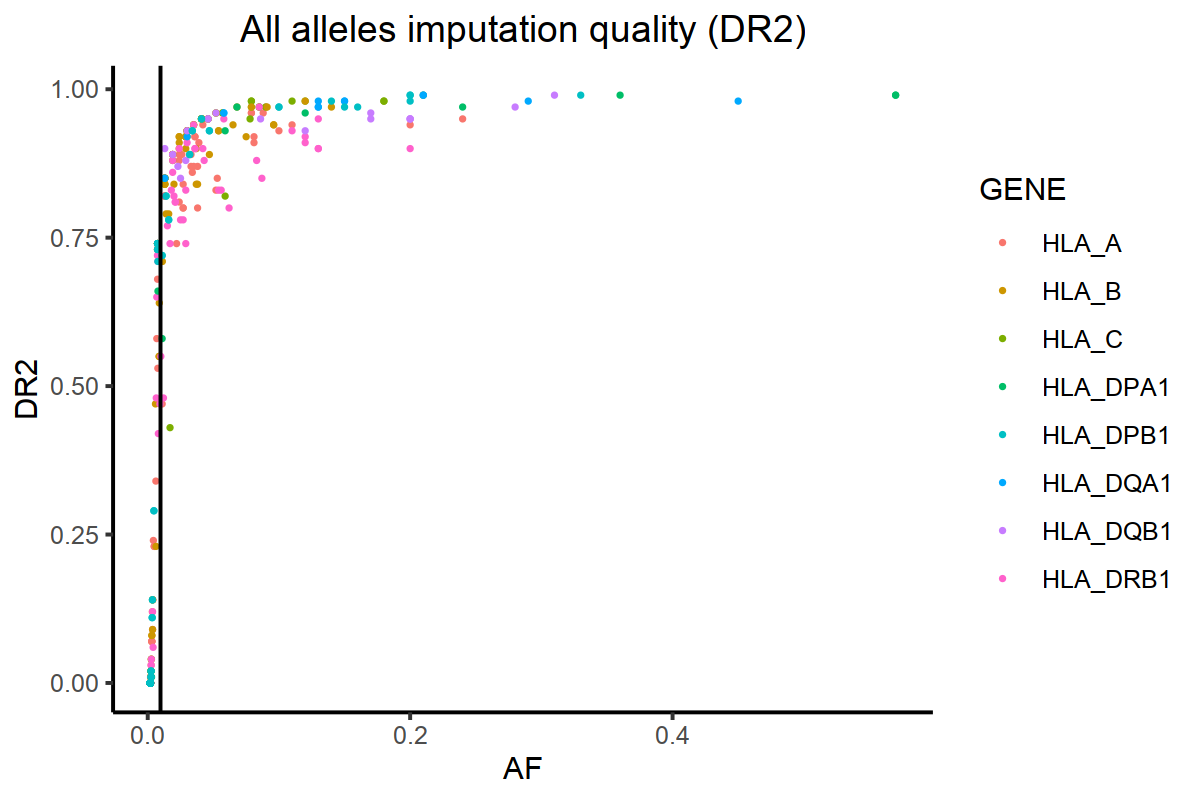

In [36]:
vcf_filepath = paste0('/data/srlab/ssakaue/share/forJoyce/Randolph2021.maf0.05.MHC.SNP2HLA.bgl.phased.vcf.gz')
vcf = read.vcfR(vcf_filepath, verbose = FALSE)
vcf@fix %>% head(4)
vcf@gt %>% head(4)

res = make_imputation_results(vcf_filepath)
res$p2

## Imputation quality for 4-digit alleles

In [37]:
vcf_4digit = res$vcf_fix_df[which(res$vcf_fix_df$ndigit == 4), ]
length(unique(vcf_4digit$ID))
vcf_4digit_Randolph = vcf_4digit %>% mutate(dataset = 'Randolph')

## Subset to only include MAF>1%
Randolph_maf1 = vcf_4digit[which(vcf_4digit$AF > 0.01), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

## Subset to only include MAF>1%
Randolph_maf5 = vcf_4digit[which(vcf_4digit$AF > 0.05), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

[1] 423

## Get Inferred HLA alleles for each individual

In [38]:
d = cbind(res$vcf_fix_df, res$vcf_hla@gt) %>% as.data.frame()

samples = colnames(res$vcf_hla@gt)
samples = samples[-1] # remove FORMAT column
length(samples)

[1] 90

## Subset to Randolph Samples

In [39]:
sample_meta <- read.csv("../../data/meta/sample_meta_Randolph.csv")
nrow(sample_meta)

[1] 176

In [40]:
results = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] %>% filter(ndigit > 2)
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results[[samp]] = d_samp_haszero %>% filter(count == 1 | count == 2)
}
saveRDS(results, '../../data/hla_alleles/randolph_updated.new.ref_results.rds')

In [41]:
results_allAlleles = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] 
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results_allAlleles[[samp]] = d_samp_haszero
}
saveRDS(results_allAlleles, '../../data/hla_alleles/randolph_updated.new.ref_all.results.rds')

## Manual Inspection

In [42]:
df_missing <- data.frame(0,0,0)
for (samp in unique(sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)])) {
    res = results[[samp]]
    
    gene_sums = tapply(res$count, res$GENE, sum)
    count_sum = sum(res$count)
    
    for (gene in c("HLA_A", "HLA_B", "HLA_C", "HLA_DRB1", "HLA_DQA1", "HLA_DQB1", "HLA_DPB1", "HLA_DPA1")) {
    if (gene_sums[gene] != 2 | is.na(gene_sums[gene])) {
        df_missing <- rbind(df_missing, c(samp, gene, gene_sums[gene]))
        #print(res)
    }
 }
}
df_missing <- df_missing[-1, ]

In [43]:
df_missing

,X0,X0.1,X0.2
,<chr>,<chr>,<chr>
2,HMN83554,HLA_DRB1,1
3,HMN83557,HLA_B,1
4,HMN83578,HLA_B,1
5,HMN83578,HLA_DRB1,1
6,HMN83579,HLA_A,1
7,HMN52532,HLA_DRB1,1
8,HMN83573,HLA_DRB1,1
9,HMN52552,HLA_A,1
10,HMN52552,HLA_DPB1,1


In [44]:
results_allAlleles[['HMN83557']] %>% filter(GENE == 'HLA_B', dosage != 0)

REF,ID,GENE,geno01,col1,col2,ndigit,count,dosage
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
A,HLA_B*08,HLA_B,0|0,0.5,"0.5,0.49,0",2,0,0.50
A,HLA_B*08:01,HLA_B,0|0,0.5,"0.5,0.49,0",4,0,0.50
A,HLA_B*40,HLA_B,0|1,1,"0,1,0",2,1,1.00
A,HLA_B*40:01,HLA_B,0|1,1,"0,1,0",4,1,1.00
A,HLA_B*44,HLA_B,0|0,0.44,"0.56,0.44,0",2,0,0.44
A,HLA_B*44:02,HLA_B,0|0,0.43,"0.57,0.43,0",4,0,0.43
A,HLA_B*51,HLA_B,0|0,0.01,"0.99,0.01,0",2,0,0.01
A,HLA_B*51:01,HLA_B,0|0,0.01,"0.99,0.01,0",4,0,0.01


In [45]:
results <- results[- which(names(results) %in% unique(df_missing$X0))]
i = 0
for (name in names(results)) {
    res = results[[name]][,c('ID', 'GENE', 'count')]
    # List of alleles (save as XXX-XXX_alleles.txt)
    write.csv(res, paste0('../../data/hla_alleles/Randolph_alleles/', 
                          name, '_alleles.csv'), row.names = FALSE, quote = FALSE)
    i = i + 1
}
print(i)
write.table(data.frame(names(results)), 
            "../../data/hla_alleles/Randolph_alleles/Randolph_final_samples.txt", 
            col.names = FALSE, row.names = FALSE, quote = FALSE)

[1] 73


In [46]:
## Make Supplementary Table
results_table = bind_rows(results, .id = 'Geno_ID') %>% select(Geno_ID, ID, GENE, geno01, dosage)
rownames(results_table) = c(1:nrow(results_table))
results_table = left_join(results_table, sample_meta[, c('Geno_ID', 'Sample')], by = 'Geno_ID')[, c(1, 6, 2, 3, 4, 5)]
colnames(results_table) = c('Geno_ID', 'Sample', 'Allele', 'Gene', 'GT', 'dosage')
write.csv(results_table, '../../data/hla_alleles/HLA_alleles_table_Randolph.csv')
results_table %>% head(4)
results_table$Sample %>% unique() %>% length()

,Geno_ID,Sample,Allele,Gene,GT,dosage
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,HMN83551,HMN83551_NI,HLA_A*02:01,HLA_A,1|1,2
2,HMN83551,HMN83551_flu,HLA_A*02:01,HLA_A,1|1,2
3,HMN83551,HMN83551_NI,HLA_C*05:01,HLA_C,1|0,1
4,HMN83551,HMN83551_flu,HLA_C*05:01,HLA_C,1|0,1


[1] 146

# New Panel | SNP2HLA | OneK1K

## Read in Imputation File

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,27970031,rs149946,G,T,NA,PASS,AR2=0.96;DR2=0.96;AF=0.22;IMP
6,27976200,rs9380032,G,T,NA,PASS,AR2=0.90;DR2=0.90;AF=0.022;IMP
6,27979188,rs4141691,A,G,NA,PASS,AR2=0.87;DR2=0.89;AF=0.091;IMP
6,27979625,rs10484402,A,G,NA,PASS,AR2=0.92;DR2=0.92;AF=0.034;IMP


FORMAT,1_1,2_2,3_3,4_4,6_6,7_7,8_8,9_9,10_10,⋯,1073_1074,1074_1075,1075_1076,1076_1077,1077_1078,1078_1079,1079_1080,1080_1081,1081_1082,241_242
GT:DS:GP,"0|0:0:1,0,0","1|1:1.96:0,0.04,0.96","0|1:1:0,1,0","1|0:1:0,1,0","0|1:1:0,1,0","0|0:0:1,0,0","0|1:1:0,1,0","1|0:1:0,1,0","0|0:0:1,0,0",⋯,"1|1:2:0,0,1","0|0:0:1,0,0","1|0:0.96:0.04,0.96,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:1:0,1,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","1|0:0.97:0.03,0.96,0","1|0:0.95:0.06,0.94,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|1:0.98:0.02,0.98,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","1|0:0.97:0.03,0.96,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"
GT:DS:GP,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0",⋯,"0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0","0|0:0:1,0,0"


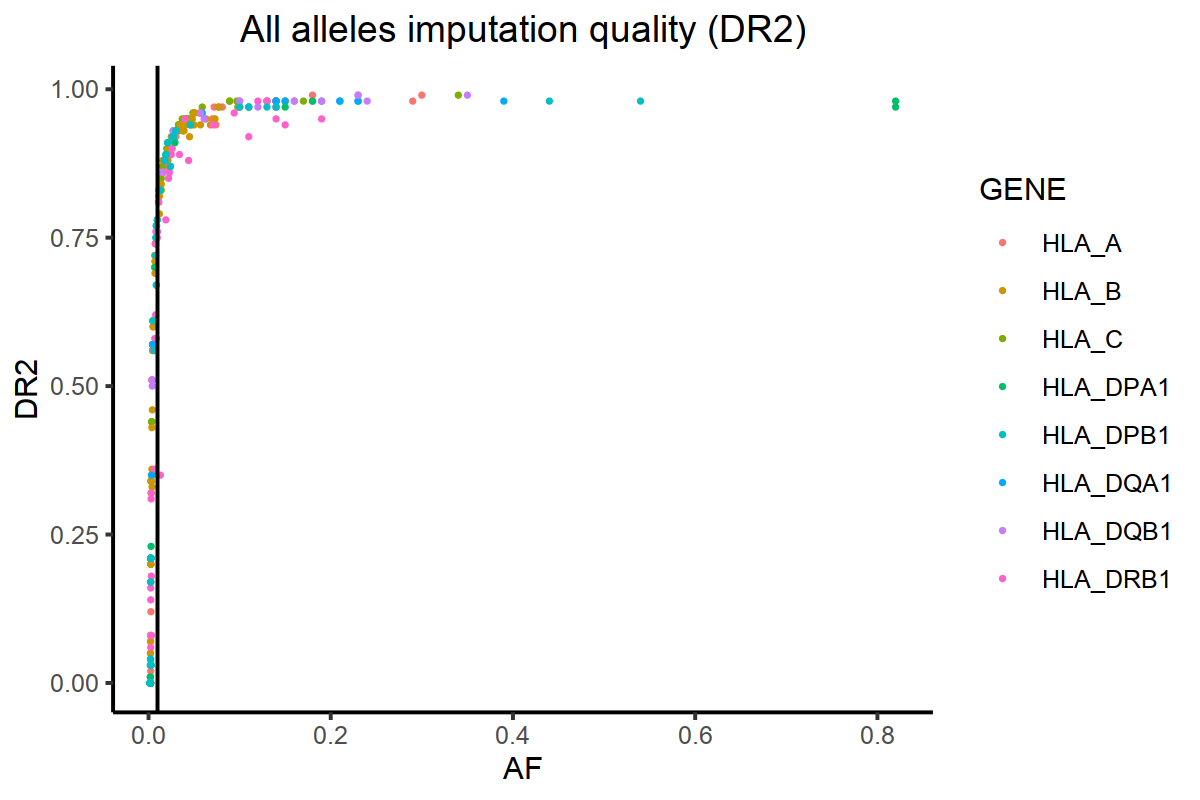

In [47]:
vcf_filepath = paste0("/data/srlab/ssakaue/share/forJoyce/1K1K.final.maf0.01.MHC.SNP2HLA.bgl.phased.vcf.gz")
vcf = read.vcfR(vcf_filepath, verbose = FALSE)
vcf@fix %>% head(4)
vcf@gt %>% head(4)

res = make_imputation_results(vcf_filepath)
res$p2

## Imputation Quality for 4-digit Alleles

In [48]:
vcf_4digit = res$vcf_fix_df[which(res$vcf_fix_df$ndigit == 4), ]
length(unique(vcf_4digit$ID))
vcf_4digit_OneK1K = vcf_4digit %>% mutate(dataset = 'OneK1K')

## Subset to only include MAF>1%
OneK1K_maf1 = vcf_4digit[which(vcf_4digit$AF > 0.01), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

## Subset to only include MAF>5%
OneK1K_maf5 = vcf_4digit[which(vcf_4digit$AF > 0.05), ] %>%
    group_by(GENE) %>%
    summarise(mean = mean(DR2))

[1] 423

## Get Inferred HLA alleles for each individual

In [49]:
d = cbind(res$vcf_fix_df, res$vcf_hla@gt) %>% as.data.frame()
samples = colnames(res$vcf_hla@gt)
samples = samples[-1] # remove FORMAT column
length(samples)

[1] 972

## Subset to 1K1K samples

In [50]:
sample_meta <- read.csv("../../data/meta/sample_meta_OneK1K.csv")
nrow(sample_meta)

[1] 969

In [51]:
results = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] %>% filter(ndigit > 2)
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results[[samp]] = d_samp_haszero %>% filter(count == 1 | count == 2)
}
saveRDS(results, '../../data/hla_alleles/1K1K_updated.new.ref_results.rds')

In [52]:
results_allAlleles = list()
for (samp in sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)]) {
    d_samp = d[, c('REF', 'ID', 'GENE', samp, 'ndigit')] 
    d_samp_haszero = separate(data = d_samp, col = samp, into = c("geno01", "col1", "col2"), sep = ":") 
    d_samp_haszero$count = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                  recode(d_samp_haszero$geno01,'0|0' = 2, '1|0' = 1, '0|1' = 1, '1|1' = 0), 
                                  recode(d_samp_haszero$geno01,'0|0' = 0, '1|0' = 1, '0|1' = 1, '1|1' = 2))
    d_samp_haszero$dosage = ifelse(d_samp_haszero[, 'REF'] == "T", 
                                   2 - as.numeric(d_samp_haszero$col1), 
                                   as.numeric(d_samp_haszero$col1))
    results_allAlleles[[samp]] = d_samp_haszero
}
saveRDS(results_allAlleles, '../../data/hla_alleles/1K1K_updated.new.ref_allresults.rds')

## Manual Inspection

In [53]:
df_missing <- data.frame(0,0,0)
for (samp in unique(sample_meta$Geno_ID[sample_meta$Geno_ID %in% colnames(d)])) {
    res = results[[samp]]
    
    gene_sums = tapply(res$count, res$GENE, sum)
    count_sum = sum(res$count)
    
    for (gene in c("HLA_A", "HLA_B", "HLA_C", "HLA_DRB1", "HLA_DQA1", "HLA_DQB1", "HLA_DPB1", "HLA_DPA1")) {
    if (gene_sums[gene] != 2 | is.na(gene_sums[gene])) {
        df_missing <- rbind(df_missing, c(samp, gene, gene_sums[gene]))
        #print(res)
    }
 }
}
df_missing <- df_missing[-1, ]
df_missing
length(unique(df_missing$X0))

,X0,X0.1,X0.2
,<chr>,<chr>,<chr>
2,690_691,HLA_B,1
3,692_693,HLA_DPB1,1
4,842_843,HLA_A,1
5,850_851,HLA_B,1
6,993_994,HLA_B,1
7,1009_1010,HLA_A,1
8,1021_1022,HLA_B,1
9,904_905,HLA_A,1
10,910_911,HLA_B,1


[1] 60

In [54]:
results <- results[- which(names(results) %in% unique(df_missing$X0))]
i = 0
for (name in names(results)) {
    res = results[[name]][,c('ID', 'GENE', 'count')]
    # List of alleles (save as XXX-XXX_alleles.txt)
    write.csv(res, paste0('../../data/hla_alleles/1K1K_alleles/', name, '_alleles.csv'), 
              row.names = FALSE, quote = FALSE)
    i = i + 1
}
print(i)

[1] 909


In [55]:
saveRDS(results, '../../data/hla_alleles/1K1K_updated.new.ref_results.rds')
saveRDS(results_allAlleles, '../../data/hla_alleles/1K1K_updated.new.ref_results.rds')
saveRDS(df_missing, '../../data/hla_alleles/1K1K_df_missing.rds')

In [56]:
## Make Supplementary Table
results_table = bind_rows(results, .id = 'Geno_ID') %>% select(Geno_ID, ID, GENE, geno01, dosage)
rownames(results_table) = c(1:nrow(results_table))
results_table = left_join(results_table, sample_meta[, c('Geno_ID', 'Sample')], by = 'Geno_ID')[, c(1, 6, 2, 3, 4, 5)]
colnames(results_table) = c('Geno_ID', 'Sample', 'Allele', 'Gene', 'GT', 'dosage')
write.csv(results_table, '../../data/hla_alleles/HLA_alleles_table_OneK1K.csv')
results_table %>% head(4)
results_table$Sample %>% unique() %>% length()

,Geno_ID,Sample,Allele,Gene,GT,dosage
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,691_692,691_692,HLA_A*02:01,HLA_A,1|0,0.98
2,691_692,691_692,HLA_A*69:01,HLA_A,0|1,1.00
3,691_692,691_692,HLA_C*06:02,HLA_C,1|1,2.00
4,691_692,691_692,HLA_B*13:02,HLA_B,0|1,1.00


[1] 909

# Table of imputation results

In [57]:
colnames(AMP_maf1) = c('Gene', 'AMP2RA')
colnames(Smillie1_maf1) = c('Gene', 'Smillie2019_GSA')
colnames(Smillie2_maf1) = c('Gene', 'Smillie2019_custom')
colnames(Randolph_maf1) = c('Gene', 'Randolph2021')
colnames(OneK1K_maf1) = c('Gene', 'OneK1K')
AMP_maf1[,2] = round(AMP_maf1[,2], 3)
maf1_table = cbind(AMP_maf1, round(Smillie1_maf1[,2], 3), 
                             round(Smillie2_maf1[,2], 3), 
                             round(Randolph_maf1[,2], 3), 
                             round(OneK1K_maf1[,2], 3))
maf1_table

Gene,AMP2RA,Smillie2019_GSA,Smillie2019_custom,Randolph2021,OneK1K
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HLA_A,0.913,0.912,0.881,0.861,0.919
HLA_B,0.880,0.890,0.908,0.897,0.908
HLA_C,0.922,0.944,0.929,0.901,0.948
HLA_DPA1,0.864,0.943,0.937,0.886,0.950
HLA_DPB1,0.927,0.905,0.884,0.909,0.922
HLA_DQA1,0.971,0.967,0.969,0.954,0.969
HLA_DQB1,0.942,0.945,0.938,0.921,0.950
HLA_DRB1,0.881,0.880,0.882,0.834,0.868


In [58]:
colnames(AMP_maf5) = c('Gene', 'AMP2RA')
colnames(Smillie1_maf5) = c('Gene', 'Smillie2019_GSA')
colnames(Smillie2_maf5) = c('Gene', 'Smillie2019_custom')
colnames(Randolph_maf5) = c('Gene', 'Randolph2021')
colnames(OneK1K_maf5) = c('Gene', 'OneK1K')
AMP_maf5[,2] = round(AMP_maf5[,2], 3)
maf5_table = cbind(AMP_maf5, round(Smillie1_maf5[,2], 3), 
                             round(Smillie2_maf5[,2], 3), 
                             round(Randolph_maf5[,2], 3), 
                             round(OneK1K_maf5[,2], 3))
maf5_table

Gene,AMP2RA,Smillie2019_GSA,Smillie2019_custom,Randolph2021,OneK1K
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HLA_A,0.960,0.966,0.966,0.914,0.966
HLA_B,0.943,0.950,0.958,0.940,0.961
HLA_C,0.965,0.977,0.973,0.951,0.976
HLA_DPA1,0.960,0.960,0.960,0.963,0.970
HLA_DPB1,0.968,0.972,0.948,0.978,0.972
HLA_DQA1,0.971,0.977,0.977,0.977,0.977
HLA_DQB1,0.982,0.972,0.967,0.950,0.971
HLA_DRB1,0.947,0.920,0.919,0.877,0.958


# All done!

In [59]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3 forcats_0.5.1      purrr_0.3.4        readr_2.1.2       
 [5] tibble_3.1.6       tidyverse_1.3.1    stringr_1.4.0      dplyr_1.0.8       
 [9] ggplot2_3.3.5      tidyr_1.2.0        vcfR_1.12.0       

loaded via a namespace (and not attached)